# <center><font color='orange'>ΑΣΚΗΣΗ 2 </font>| `Μη Επιβλεπόμενη Μάθηση`<center>
<p style="text-align: right;"><font color='grey'>
Εργαστήριο Τεχνητής Νοημοσύνης και Μηχανικής Μάθησης
<br>
Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα
</font>
<br><br>
Ευδοκία Μπαρουξή (16586) | Τζανακάκης Γιάννης (14436)
<br>
<p style="text-align: right;"><font color='grey'>
Αριθμός Ομάδας: 83
</font>
</p>

# Εισαγωγή
Σκοπός της παρούσας εργασίας είναι η εξοικείωση με έννοιες και η εφαρμογή μεθόδων της Μη Επιβλεπόμενης Μηχανικής Μάθησης, καθώς και η σύνταξη μιας παρουσίασης της παραπάνω διαδικασίας, με χρήση markdown formatting.

Για την ανάλυση, θα χρησιμοποιηθεί ένα σύνολο δεδομένων, βασισμένο στη συλλογή ταινιών [Carnegie Mellon Movie Summary Corpus](www.cs.cmu.edu/~ark/personas/).

Κάνοντας χρήση της παραπάνω συλλογής, καλούμαστε να αναπτύξουμε:
>1. **Σύστημα Συστάσεων** με βάση το **Περιεχόμενο** (Content Based Recommendation System).
>2. **Τοπολογική Απεικόνιση & Σημασιολογική Ερμηνεία** μέσω **Αυτοργανώμενων Χαρτών** (Topological Mapping using SOM).

Στα Κεφάλαια 4 και 5 περιγράφεται η διαδικασία ανάπτυξης των εφαρμογών 1 και 2 αντίστοιχα. Αναλυτικά η δομή της εργασίας, αναφέρεται στον πίνακα περιεχομένων της παρουσίασης. 

*Σημείωση*: Η παρουσίαση αναπτύχθηκε στο `jupyter notebook` και η αναπαραγωγή των `markdown cells` με διαφορετικο εργαλείο (Colab, Azure κλπ) δεν είναι πιστή (διαφορές στην αναπαραγωγή των html εντολών, του πλάτους των κελιών, του πίνακα παρουσίασης). Για το λόγο αυτό παραθέτουμε την παρακάτω παρουσίαση (κείμενο, σχόλια, έξοδοι) τόσο σε .ipynb όσο και σε .pdf μορφή.

# CMU Summary Corpus

Λίγα λόγια για την προέλευση των δεδομένων:
<div class="alert alert-block alert-info">
Η συλλογή ταινιών [Carnegie Mellon Movie Summary Corpus](www.cs.cmu.edu/~ark/personas/) εξήχθη από διαδικτυακούς πόρους, το Νοέμβριο του 2012 και περιλαμβάνει:
<br>
<br>
-   Δεδομένα από **42306 περιλήψεις ταινιών** (English-language Wikipedia, 2/11/2012 dump)
<br>
-   Μεταδεδομένα από **81741 ταινίες και 450669 χαρακτήρες ταινιών** (Freebase, 4/11/2012 dump). 
</div>


Σχετικό Άρθρο:
>"Learning Latent Personas of Film Characters"
<br>
>*David Bamman, Brendan O'Connor & Noah Smith*
<br>
>*ACL 2013, Sofia, Bulgaria, August 2013*

<p style="text-align: right;"> Πηγή: http://www.cs.cmu.edu/~ark/personas/ </p>

<div class="alert alert-warning">
  <strong>Προαπαιτούμενες Βιβλιοθήκες:</strong>
</div>
<br>
Για την αναπαραγωγή του κώδικα της εργασίας, απαιτείται η εγκατάσταση/ενημέρωση των παρακάτω βιβλιοθηκών:

In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install --upgrade somoclu
!pip install --upgrade scipy
!pip install --upgrade time

## To sample

Το dataset με το οποίο θα δουλέψουμε, είναι ένα sample 5000 ταινιών (μεταδεδομένα & περιλήψεις) από την αρχική συλλογή ($\approx 8^*$ downsampling).
<br>
Κάνουμε χρήση του παρεχόμενου στην εκφώνηση κώδικα για την εξαγωγή του sample:

In [9]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t', header=None, quoting=3, error_bad_lines=False)

In [10]:
import numpy as np

team_seed_number = 83

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

In [11]:
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] 
categories = df_data_1.iloc[:, [3]].values[my_index]
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index]
summaries =  df_data_1.iloc[:, [5]].values[my_index]
corpus = summaries[:,0].tolist()

### Μια πρώτη ματιά | EDA

Κάθε ταινία στη συλλογή μας έχει ένα ID (πχ η ταινία Django έχει ID = 3239), μέσω του οποίου έχουμε πρόσβαση στον τίτλο:

In [6]:
print(titles[3239][0])

Django


και τις κατηγορίες στις οποίες ανήκει η ταινία:

In [9]:
print(categories[3239][0])

"Action/Adventure",  "Western",  "Spaghetti Western",  "Action",  "World cinema"


Βλέπουμε ότι η κάθε ταινία ανήκει σε κατά μέσο όρο 4 κατηγορίες:

In [11]:
category_count = 0
for ID in range(5000):
    category_count += np.sum(catbins[ID])
cat_per_film_avg = round(category_count/5000)
print("Average \"Categories per Movie\" Number:\t", cat_per_film_avg)

Average "Categories per Movie" Number:	 4


Οι κατηγορίες δίνονται επίσης σε μορφή one-hot-encoding, ως διάνυσμα με όλες τις (322) κατηγορίες και "1" σε όσες ανήκει η κάθε ταινία (format για SOM):

In [12]:
print(catbins[3239])

[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]


Ο τίτλος και οι κατηγορίες -που αναλύσαμε μέχρι τώρα- αποτελούν τα μεταδεδομένα της ταινίας.<br>
Τέλος, μας δίνεται η περίληψη της κάθε ταινίας (δεδομένα), όπως αυτή υπήρχε στην αγγλόφωνη Wikipedia το Νοέμβριο του 2012, σε 2 formats.<br>
Ως λίστα από συμβολοσειρές:

In [13]:
corpus[3239]

" Django  is a drifter who drags around a coffin that conceals a machine gun. He rescues a young woman, María , from being murdered by bandits led by Major Jackson , a man whom Django is seeking revenge on for the murder of his wife. After killing most of Jackson's men, Django makes a deal with a Mexican bandit general, Hugo Rodriguez , who is in conflict with Jackson, and the two steal a large quantity of gold from a Mexican Army fort . When Rodriguez drags his feet in giving Django his share, he and Maria steal the gold. Unfortunately, the gold falls into quicksand. When Rodriguez catches up to them, María is shot  and Django's hands are crushed. Rodríguez and his men are massacred by Jackson and the Mexican Army when the bandits return to Mexico. Jackson then goes looking for Django in a cemetery after killing Nathaniel. However, Django, who has bitten the trigger-guard off his pistol, kills Jackson and his five surviving men by pressing the trigger against a cross  and repeatedly d

και ως πίνακας συμβολοσειρών:

In [14]:
summaries[3239]

array([" Django  is a drifter who drags around a coffin that conceals a machine gun. He rescues a young woman, María , from being murdered by bandits led by Major Jackson , a man whom Django is seeking revenge on for the murder of his wife. After killing most of Jackson's men, Django makes a deal with a Mexican bandit general, Hugo Rodriguez , who is in conflict with Jackson, and the two steal a large quantity of gold from a Mexican Army fort . When Rodriguez drags his feet in giving Django his share, he and Maria steal the gold. Unfortunately, the gold falls into quicksand. When Rodriguez catches up to them, María is shot  and Django's hands are crushed. Rodríguez and his men are massacred by Jackson and the Mexican Army when the bandits return to Mexico. Jackson then goes looking for Django in a cemetery after killing Nathaniel. However, Django, who has bitten the trigger-guard off his pistol, kills Jackson and his five surviving men by pressing the trigger against a cross  and repea

Βλέπουμε ότι όλο το **corpus** (του sample μας) έχει **1.557.452 λέξεις**, και κάθε **περίληψη** έχει κατά μέσο όρο **311 λέξεις**:

In [15]:
word_count = 0
for ID in range(5000):
    word_count += len(corpus[ID].split())
summary_word_avg = round(word_count/5000)

print("Total Words in Corpus:\t\t", word_count)
print("Average Words per Summary:\t", summary_word_avg)

Total Words in Corpus:		 1557452
Average Words per Summary:	 311


<div style="width:image width px; 
            font-size:90%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.1em">
    <img src="https://img1.goodfon.com/original/1920x1282/9/9b/mike-mitchell-gangs-of-new.jpg" 
         alt="alternate text" 
         width = 1000
         style="padding-bottom:0.1em;"/>
        Movie Characters @goodfon.com <br> 
        <a href="https://www.goodfon.com/wallpaper/mike-mitchell-gangs-of-new.html" 
           style="float: right;"> 
           Πηγή 
        </a>
    </div>
</div>   
<div style="width:image width px; 
            font-size:90%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.1em">
    <img src="https://townsquare.media/site/442/files/2014/04/mondo-marvel-header.jpg?w=980&q=75" 
         alt="alternate text" 
         width = 680
         style="padding-bottom:0.1em;"/>
        Superheroes @screencrush.com <br> 
        <a href="https://screencrush.com/superheroes-take-a-breather-in-mike-mitchells-marvel-mondo-show-friday-night/" 
           style="float: right;"> 
           Πηγή 
        </a>
    </div>
</div>   

# Σύστημα Προτάσεων

Η πρώτη εφαρμογή που καλούμαστε να αναπτύξουμε, είναι ένα **Content Based Recommendation System** για ταινίες.

Το σύστημα προτάσεων θα εκπαιδευτεί πάνω στη συλλογή ταινιών που αντιστοιχεί στην ομάδα μας (*ομάδα 83*) και θα προτείνει αυτόματα στο χρήστη ταινίες από την παραπάνω συλλογή, με παρόμοιο περιεχόμενο με αυτές που ο χρήστης έχει προηγουμένως αξιολογήσει θετικά.

Η υλοποίηση του συστήματος θα γίνει μέσω της συνάρτησης **content_recommender** που θα δέχεται ως ορίσματα:

1. Την ταινία με βάση την οποία θα κάνουμε τις συστάσεις (**target_movie**),
2. Το μέγιστο πλήθος ταινιών προς σύσταση (**max_recommendations**)

και θα επιστρέφει τις προτεινόμενες ταινίες.

Ας ξεκινήσουμε την ανάπτυξη:

### Μετατροπή σε TF-IDF

Πρώτο βήμα είναι να μετατραπεί το corpus των περιλήψεων, σε TFIDF αναπαράσταση. To TFIDF (Term Frequency - Inverse Document Frequency) είναι ένα στατιστικό μέτρο που ποσοτικοποιεί τη σχετικότητα μιας λέξης με ένα κείμενο ή μια συλλογή κειμένων.

#### Μερικοί Ορισμοί
<div class="alert alert-block alert-success">
Για μια λέξη $i$ σε ένα κείμενο $j$ μια συλλογής κειμένων $D$, το $TFIDF$ ορίζεται μέσω των $TF$ και $IDF$ ως:
<br><br>
$$TFIDF_{i,j,D} = TF_{i,j}\cdot IDF_{i,D}$$
<br>
Η σχετική συχνότητα $TF$ εμφάνισης μιας λέξης $i$ σε ένα κείμενο $j$ ορίζεται ως:$$TF_{i,j} = \frac{n_{i,j}}{\sum n_{j}}$$

Η σχετική συχνότητα $DF$ εμφάνισης μιας λέξης $i$ σε μια συλλογή κειμένων $D$, είναι ο λόγος του πλήθους των κειμένων που εμφανίζεται η λέξη, προς το πλήθος των κειμένων της συλλογής. Το $IDF_i$ είναι ο λογάριθμος του $\frac{1}{DF_i}$ και συμβολίζεται με:$$IDF_{i}= \log{\frac{1}{DF_i}}$$
</div>


Θα κάνουμε χρήση της `TfidfVectorizer` για να εξάγουμε τα TFIDF vectors κάθε κειμένου στο corpus, για αρχή χωρίς κάποια προεπεξεργασία στα δεδομένα μας:

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer  # κώδικας εκφώνησης

vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

In [17]:
corpus_tf_idf.shape

(5000, 49147)

Παρατηρούμε ότι υπάρχουν 49147 διαφορετικές λέξεις που εμφανίζονται στο corpus. Κομμάτι της πρώτης εφαρμογής μας, θα είναι να βελτιστοποιήσουμε με τεχνικές προεπεξεργασίας κειμένου για NLP (φιλτράρισμα, κανονικοποίηση κλπ) το corpus, για να τροφοδοτήσουμε το σύστημα προτάσεών μας, το οποίο θα συγκρίνει την πληροφορία ανάμεσα στις περιλήψεις των ταινιών και θα εξάγει τις ομοιότητες.

Πρώτα αναπτύσσουμε το σύστημα προτάσεων:

### Υλοποίηση της content_recommender

Έχοντας τα **μη βελτιστοποιημένα** tfidf vectors, μπορούμε να υλοποιήσουμε τη συνάρτηση `content recommender` που ενσωματώνει τη λειτουργικότητα του content baser recommendation system. Για μια είσοδο `target_movie` θα συγκρίνουμε τα tfidf διανύσματα του κάθε κειμένου στη συλλογή με αυτό της `target_movie` και θα ταξινομούμε το corpus με βάση την ομοιότητα κάθε κειμένου με αυτό της ταινίας στόχου.<br>
Η συνάρτηση θα επιστρέφει τις `max_recommendations` πρώτες ταινίες με βάση την ομοιότητα τους με την `target_movie`.


Ένα δημοφιλές και εύχρηστο μέτρο ομοιότητας 2 διανυσμάτων, είναι η διαφορά στη γωνία τους. Το συνημίτονο της γωνίας $φ$ μεταξύ των $\vec{x}$,$\vec{y}\in \rm I\!R^n$ είναι:$$ \cos{φ} = \frac{\vec{x} \cdot \vec{y}}{||\vec{x}||_2\cdot||\vec{y}||_2}$$
H ομοιότητα συνήθως είναι ένας δείκτης που κανονικοποιεί μια μετρική (οι μετρικές έχουν πεδίο τιμών εν γένει στον $\rm I\!R^+$).<br>Για παράδειγμα, έστω η Ευκλείδια απόσταση: $\text{Euclidean_Dist} (x,y) = ||x-y||_2$ με $\text{Euclidean_Dist} (x,y) \in \rm I\!R^+$. Τότε: $$\text{Euclidean_Sim} (x,y) = \frac{1}{1+\text{Euclidean_Dist} (x,y)} \Rightarrow 0 \leq \text{Euclidean_Sim} \leq 1 $$ Το συνημίτονό μιας γωνίας όμως είναι εκ φύσεως φραγμένη συνάρτηση. Άρα αν το συν/ονο της γωνίας μετρά την απόσταση, η ομοιότητα θα εκφράζεται ως:
$$ \text{Cosine_Sim} (x,y) = 1 - \cos{φ} = 1 - \frac{\vec{x} \cdot \vec{y}}{||\vec{x}||_2\cdot||\vec{y}||_2}$$ 
Στην περίπτωσή μας, ταξινομούμε την **απόσταση** της `target_movie` από κάθε ταινία με **αύξουσα σειρά** (ισοδύναμα με ταξινόμηση ομοιότητας με φθίνουσα σειρά) και επιστρέφουμε τις προτάσεις.

Γράφουμε έναν printer για το σύστημα προτάσεων (`recommendation_printer`) και υλοποιούμε την `content_recommender` κάνοντας χρήση της συνάρτησης [cosine](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) που ανήκει στο πακέτο `distance` της `sp.spacial` για να εξάγουμε τις αποστάσεις των ταινιών:

In [38]:
from scipy.spatial import distance

def recommendation_printer(sorted, max_recommendations):
    for movie in range(max_recommendations+1):
        print('\n', end = " ")   
        for i in range(60):
            print('_', end = "")
        if (movie == 0):
            print(' TARGET MOVIE ______________________ ID |', sorted[movie],'_____')
        else:
            print(' RECOMMENDATION', movie,'__________________ ID |', sorted[movie],'_____') 
        print(':___TITLE_____:',''.join(titles[sorted[movie]]))
        print(':___CATEGORY__:',''.join(categories[sorted[movie]]))    
        print(':___SUMMARY___:',corpus[sorted[movie]])
        if (movie == 0):
            print("\n _ _ _ _ _ _ _ _",max_recommendations,"RECOMMENDED MOVIES", end = "")
            for i in range(38):
                print(' _', end = "") 
            print('')

    
def content_recommender(target_movie, max_recommendations):
    corpus_size = corpus_tf_idf.shape[0]
    similarity = np.zeros(corpus_size)
    
    target = corpus_tf_idf[target_movie].toarray()
    for ID in range(corpus_size):
        candidate = corpus_tf_idf[ID].toarray()
        similarity[ID] = distance.cosine(target, candidate)  

    rank_list = np.argsort(similarity)
    recommendation_printer(rank_list, max_recommendations)

In [39]:
content_recommender(3239,3)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 3239 _____
:___TITLE_____: Django
:___CATEGORY__: "Action/Adventure",  "Western",  "Spaghetti Western",  "Action",  "World cinema"
:___SUMMARY___:  Django  is a drifter who drags around a coffin that conceals a machine gun. He rescues a young woman, María , from being murdered by bandits led by Major Jackson , a man whom Django is seeking revenge on for the murder of his wife. After killing most of Jackson's men, Django makes a deal with a Mexican bandit general, Hugo Rodriguez , who is in conflict with Jackson, and the two steal a large quantity of gold from a Mexican Army fort . When Rodriguez drags his feet in giving Django his share, he and Maria steal the gold. Unfortunately, the gold falls into quicksand. When Rodriguez catches up to them, María is shot  and Django's hands are crushed. Rodríguez and his men are massacred by Jackson and the Mexican Army when the bandits return t

Υλοποιήσαμε μια πρώτη μορφή του συστήματος συστάσεων το οποίο -όπως βλέπουμε παραπάνω- δεν προτείνει ικανοποιητικά σχετικές (με την ταινία στόχο) ταινίες. Στη συνέχεια εφαρμόζουμε ορισμένες τεχνικές που μετασχηματίζουν το corpus για ακριβέστερες προτάσεις.

### Βελτιστοποίηση
Πριν βελτιστοποιήσουμε, χρειάζεται να κάνουμε μια μικρη προεπεξεργασία στις περιλήψεις.<br>
#### Προεπεξεργασία
Για κάθε κείμενο της συλλογής, κατασκευάζουμε μια λιστα `corpus_words` που θέλουμε να περιέχει 1 λέξη της περίληψης ανά θέση:

In [11]:
%%time
#nltk.download('punkt') # χρειάζεται για το tokenizer
import nltk

corpus_words = []   #split every summary in words
for summary in corpus:
  corpus_words.append(nltk.word_tokenize(summary))

CPU times: user 25.8 s, sys: 157 ms, total: 26 s
Wall time: 26.8 s


Πράγματι:

In [12]:
print(corpus[3239][844:899])
print(corpus_words[3239][168:178])

Django, who has bitten the trigger-guard off his pistol
['Django', ',', 'who', 'has', 'bitten', 'the', 'trigger-guard', 'off', 'his', 'pistol']


Έχοντας πλέον τη λίστα `corpus_words`, θέλουμε να **φιλτράρουμε την πληροφορία που θεωρούμε αδιάφορη ή και παραπλανητική για την ανάλυσή μας** και να εφαρμόσουμε κάποια τεχνική **κανονικοποίησης κειμένου** για να ολοκληρώσουμε τη βελτιστοποίησή μας.
#### Φιλτράρισμα
##### 1ο Φίλτρο
Το πρώτο φίλτρο που εφαρμόζουμε, είναι το thorough_filter του οποίου ο κώδικας παρέχεται στην εκφώνηση.<br>
Το φίλτρο απομονώνει:
* Σημεία Στίξης
* Λέξεις που περιέχουν Σημεία Στίξης

In [13]:
import string

def thorough_filter(words):
    optimised_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if True not in pun:
            optimised_words.append(word)
    return optimised_words

In [14]:
%%time

clean_words = []
for words in corpus_words:
    clean_words.append(thorough_filter(words))

CPU times: user 2.85 s, sys: 6.41 ms, total: 2.86 s
Wall time: 2.86 s


Το φίλτρο δρα και απομονώνει τις σχετικές λέξεις:

In [15]:
print(' '.join(corpus_words[390][174:179]))
print(' '.join(clean_words[390][154:158]))

The young bride 's discomfort
The young bride discomfort



Το αποτέλεσμα έχει βέβαια και ορισμένες παρενέργειες. Λέξεις που ίσως έχουν αξία φιλτράρονται.<br>
Ένα τέτοιο παράδειγμα είναι η λέξη trigger-guard στην παρακάτω φράση:

In [16]:
print(' '.join(corpus_words[3239][168:178]))
print(' '.join(clean_words[3239][147:155]))

Django , who has bitten the trigger-guard off his pistol
Django who has bitten the off his pistol


##### 2ο Φίλτρο
To δεύτερο φίλτρο, αφορά σε λέξεις -αποδεκτές γραμματικά και συντακτικά- που δε συνεισφέρουν νοηματικά στην ανάλυσή μας, όπως άρθρα, προθέσεις, μετοχές αντωνυμίες, επιρρήματα κα. Στο δικό μας φίλτρο εμπεριέχονται:
* Η συλλογή των αγγλόφωνων stopwords της `nltk`
* 2 αρχεία με stopwords που συλλέξαμε από διαδικτυακούς πόρους και παραθέτουμε στην υποβολή
* μια χειροποίητη λίστα με λέξεις που σχετίζονται με τα μεταδεδομένα της ταινίας:

In [17]:
nltk.download('stopwords')

g = open("gist_stopwords.txt", "r")
gist_stop = g.read().split('\n')

e = open("extra_stopwords.txt", "r")
extra_stop = e.read().split('\n')

english_stop = nltk.corpus.stopwords.words('english')
movie_word_list = ['cast', 'category', 'character', 'cinema', 'director', 'direction', 'film', 'genre', 'plot', 'scene', 'screen', 'story']

stopwords_filter = english_stop + gist_stop + extra_stop + movie_word_list

print('Stopwords Filter Length:\t',len(stopwords_filter))
print('Small Content Sample:\t\t', ' '.join(stopwords_filter[32:41]))

Stopwords Filter Length:	 2204
Small Content Sample:		 their theirs themselves what which who whom this that


In [18]:
%%time

meaningful_words = []
for words in clean_words:
  meaningful_words.append([m_word.lower() for m_word in words if m_word.lower() not in stopwords_filter])

CPU times: user 32.5 s, sys: 20.2 ms, total: 32.5 s
Wall time: 32.5 s


Βλέπουμε ότι η λίστα `meaningful_words` περιέχει πλέον τις λέξεις που προσφέρουν χρήσιμη πληροφορία για το σύστημά μας αλλά παραμένουν τα ονόματα χαρακτήρων:

In [19]:
print(' '.join(clean_words[30][0:17]))
print(' '.join(meaningful_words[30][0:9]))

Conrad Rad McCrae who is on the trail of the man who murdered his lifelong friend Benjamin
conrad rad mccrae trail man murdered lifelong friend benjamin


##### 3ο Φίλτρο
Τελευταίο αφήνουμε το φιλτράρισμα των κύριων ονομάτων. Στο φίλτρο ονομάτων μας περιέχονται:
* Τα αντρικά και γυναικεία ονόματα στα Αγγλικά, από τη βιβλιοθηκη `nltk`
* Ένα αρχείο με επώνυμα από διάφορες εθνικότητες που συλλέξαμε από διαφορετικούς διαδ. πόρους και παραθέτουμε στην υποβολή μας
Τυπώνουμε το μέγεθος και ένα μικρό δείγμα του φίλτρου:

In [20]:
nltk.download('names')
from nltk.corpus import names

s = open("surnames.txt", "r")
surnames = [name.lower() for name in s.read().split('\n')]

male_names = [name.lower() for name in names.words('male.txt')]
female_names = [name.lower() for name in names.words('female.txt')]

names_filter = male_names + female_names + surnames

print('Names Filter Length:\t\t',len(names_filter))
print('Small Content Sample:\t\t', ' '.join(names_filter[150:160]))

Names Filter Length:		 34002
Small Content Sample:		 apollo apostolos aram archibald archibold archie archon archy arel ari


In [21]:
%%time

optimised_words = []
for words in meaningful_words:
  optimised_words.append([op_word for op_word in words if op_word not in names_filter])

CPU times: user 6min 58s, sys: 236 ms, total: 6min 58s
Wall time: 6min 59s


Το φίλτρο αφαιρεί τα ονόματα και επώνυμα χαρακτήρων με επιτυχία:

In [22]:
print(' '.join(meaningful_words[3239][29:38]))
print(' '.join(optimised_words[3239][22:28]))

general hugo rodriguez conflict jackson steal large quantity gold
general conflict steal large quantity gold


### Κανονικοποίηση
Επόμενο βήμα είναι να απαλαγούμε από γραμματικούς και συντακτικούς περιορισμούς της γλώσσας (πχ καταλήξεις, κλίσεις, χρόνοι, γένη κλπ). Για αυτή τη διαδικασία, θα ακολουθήσουμε 2 πιθανές προσεγγίσεις:
#### Λημματοποίηση

In [23]:
%%time
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()
lem_words = []
for summary in optimised_words:
  lem_words.append(' '.join([str(lemma) for lemma in [lem.lemmatize(word) for word in summary]]))

CPU times: user 6.64 s, sys: 100 ms, total: 6.74 s
Wall time: 6.84 s


#### Αποκοπή Καταλήξεων

In [24]:
%%time

#nltk.download('rslp')
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
stem_words = []
for summary in optimised_words: 
  stem_words.append(' '.join([str(stem) for stem in [stemmer.stem(word) for word in summary]]))

CPU times: user 21.8 s, sys: 100 ms, total: 21.9 s
Wall time: 21.9 s


>* Η αποκοπή καταλήξεων (Stemming) υλοποιείται μέσω του Porter Stemmer, όπου μέσω **συμβολικών κανόνων** αφαιρούνται συνήθη προθέματα και επιθέματα μιας λέξης, ώστε να εξαχθεί η ρίζα της. Η ρίζα αυτή **δεν ανήκει απαραίτητα στη φυσική γλώσσα**. Το Stemming ενισχύει την ανάκληση (Recall).


>* Από την άλλη, η λημματοποίηση (Lemmatisation) προσεγγίζει **γλωσσολογικά** την κανονικοποίηση και εξάγει το κατάλληλο λήμμα μβτ. μορφολογική ανάλυση της λέξης και ένα λεξικό. Το λήμμα αυτό **ανήκει πάντα στη φυσική γλώσσα**. Το Lemmatization ενισχύει την ακρίβεια (Precision).

Όπως διαπιστώσαμε, η λημματοποίηση σέβεται περισσότερο την αρχική έννοια της λέξης μέσα στο κείμενο αλλά τείνει να συγχέει (αν δεν διορθωθεί manually) τα μέρη του λόγου (πχ χαρακτηρίζει επίθετα και ρήματα ως ουσιαστικά κλπ, με αρνητικές παρενέργειες στην αναζήτηση ομοιότητας), ενώ η αποκοπή συνήθως υπεραποδίδει της λημματοποίησης σε αντίστοιχες εφαρμογές, αλλά αυξάνει κι αυτή -υπο συνθηκες- το θόρυβο (πολλές συσχετίσεις που δεν προκύπτουν στο αρχικό κείμενο). Ένα τέτοιο παράδειγμα είναι η λέξη *authority* που το lemmatisation σέβεται αλλά το stemming μετατρέπει σε *author* (συγγραφέας, συντάκτης, σχέση και με authorisation) και αλλοιώνει με προφανή τρόπο τη συσχέτιση της αρχικής και τελικής έννοιας της λέξης:

In [25]:
print('Initial:\t', ' '.join(optimised_words[100][8:13]))
print('Lemmas:\t\t', lem_words[100][61:100])
print('Roots:\t\t', stem_words[100][55:87])

Initial:	 ecclesiastical authority small san helps
Lemmas:		 ecclesiastical authority small san help
Roots:		 ecclesiast author small san help


### Εποπτεία της Βελτιστοποίησης
Έχοντας ακολουθήσει τα παραπάνω βήματα, μπορούμε να δούμε την πληροφορία να φιλτράρεται ανάμεσα στα στάδια. Μετράμε το πλήθος λέξεων και χαρακτήρων στο corpus ανάμεσα στα στάδια φιλτραρίσματος και παράγουμε το σχετικό plot:

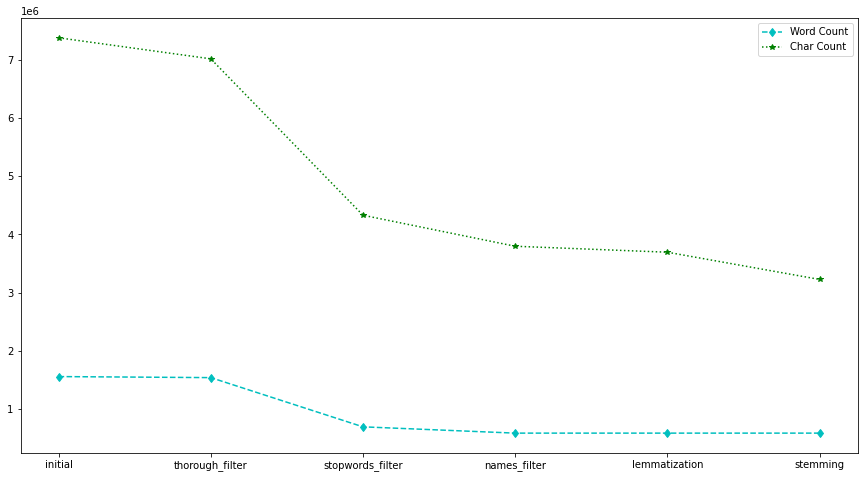

Initial Corpus Total Word Count:	 1557452
Post Optitimisation Total Word Count:	 586191
Corpus Total Word Shrink:		 62.4 %
Corpus Character Shrink:		 56.3 %


In [27]:
import matplotlib.pyplot as plt

word_count = [0] * 6
char_count = [0] * 6

for summary in corpus:
    word_count[0] += len(summary.split())
    char_count[0] += len(''.join(summary.split()))
  
for summary in clean_words:    
    word_count[1] += len(summary)
    char_count[1] += len(''.join(summary))

for summary in meaningful_words:    
    word_count[2] += len(summary)    
    char_count[2] += len(''.join(summary))

for summary in optimised_words:    
    word_count[3] += len(summary)  
    char_count[3] += len(''.join(summary))

for summary in lem_words:    
    word_count[4] += len(summary.split())  
    char_count[4] += len(''.join(summary.split()))

for summary in stem_words:    
    word_count[5] += len(summary.split())
    char_count[5] += len(''.join(summary.split()))
    
word_shrink_percentage = round(100*(1-word_count[5]/word_count[0]),1)  
char_shrink_percentage = round(100*(1-char_count[5]/char_count[0]),1)  

fig, ax = plt.subplots(figsize = [15, 8])
labels = ["initial", "thorough_filter", "stopwords_filter", "names_filter", "lemmatization", "stemming"]   

ax.plot(labels, word_count,'cd--' ,label = "Word Count")
ax.plot(labels, char_count, 'g*:', label = "Char Count")
ax.legend()
plt.show()

print('Initial Corpus Total Word Count:\t', word_count[0])
print('Post Optitimisation Total Word Count:\t', word_count[5])
print('Corpus Total Word Shrink:\t\t', word_shrink_percentage,'%')
print('Corpus Character Shrink:\t\t', char_shrink_percentage,'%')

Μπορούμε να διαπιστώσουμε τη διαφορά στο μέγεθος και σε επίπεδο περίληψης.<br>
Τυπώνουμε το πλήθος λέξεων και χαρακτήρων για τυχαίες ταινίες, ανάμεσα στα στάδια φιλτραρίσματος:

In [36]:
random_ids = [356, 687, 300, 1529, 1501]

for ID in random_ids:
    print(' '.join(titles[ID]))
    print("\t\t\t\tWord Count\tChar Count")
    print("Initial Summary:\t\t",len(corpus_words[ID]),"\t\t",len(''.join(corpus_words[ID])))
    print("Filtered Summary:\t\t",len(optimised_words[ID]),"\t\t",len(''.join(optimised_words[ID])))
    print("Lemmatized Summary:\t\t -/-\t\t",len(''.join(lem_words[ID].split())))
    print("Stemmed Summary:\t\t -/-\t\t",len(''.join(stem_words[ID].split())),"\n")

Raajneeti
				Word Count	Char Count
Initial Summary:		 940 		 4084
Filtered Summary:		 374 		 2452
Lemmatized Summary:		 -/-		 2413
Stemmed Summary:		 -/-		 2166 

The Green Archer
				Word Count	Char Count
Initial Summary:		 232 		 1038
Filtered Summary:		 88 		 578
Lemmatized Summary:		 -/-		 566
Stemmed Summary:		 -/-		 489 

Puppet Master 4
				Word Count	Char Count
Initial Summary:		 753 		 3144
Filtered Summary:		 254 		 1694
Lemmatized Summary:		 -/-		 1656
Stemmed Summary:		 -/-		 1451 

Resident Evil: Damnation
				Word Count	Char Count
Initial Summary:		 1702 		 7340
Filtered Summary:		 561 		 3646
Lemmatized Summary:		 -/-		 3538
Stemmed Summary:		 -/-		 3044 

Kaal
				Word Count	Char Count
Initial Summary:		 386 		 1688
Filtered Summary:		 141 		 929
Lemmatized Summary:		 -/-		 903
Stemmed Summary:		 -/-		 786 



Καθώς και την πορεία του κειμένου μιας περίληψης για εποπτεία των σταδίων φιλτραρίσματος:

In [37]:
ID = 4336

print("Movie Title:\t\t",' '.join(titles[ID]))
print("\nInitial Summary _______",len(corpus_words[ID]),"words &",len(''.join(corpus_words[ID])),"characters\n")
print(' '.join(corpus_words[ID]),"\n")
print("Filtered Summary ______",len(optimised_words[ID]),"words &",len(''.join(optimised_words[ID])),"characters\n")
print(' '.join(meaningful_words[ID]),"\n")
print("Lemmatized Summary ____ -/- words &",len(''.join(lem_words[ID].split())),"characters\n")
print(lem_words[ID],"\n")
print("Stemmed Summary _______ -/- words &",len(''.join(stem_words[ID].split())),"characters\n")
print(stem_words[ID],"\n")

Movie Title:		 Django Unchained

Initial Summary _______ 103 words & 450 characters

Django is a slave living in the Deep South after having been separated from his wife Broomhilda . When Django is held for a slave auction , Dr. King Schultz , a bounty hunter who poses as a dentist , frees Django from his vicious masters , the Speck brothers , and gives him the option of hunting down and killing the Brittle Brothers , a ruthless gang of killers whom only Django has seen . In return , Schultz will free Django from slavery completely and help rescue Broomhilda from the plantation of the charming but ruthless owner , Calvin Candie . 

Filtered Summary ______ 37 words & 247 characters

django slave living deep south separated wife broomhilda django held slave auction king schultz bounty hunter poses dentist frees django vicious masters speck brothers option hunting killing brittle brothers ruthless gang killers django return schultz free django slavery completely rescue broomhilda plantati

### Tο δικό μας Σύστημα Προτάσεων
Έχοντας ολοκληρώσει τη βελτιστοποίηση του dataset, θα εξάγουμε πάλι τα TFIDF vectors των λέξεων κάθε περίληψης στο `corpus_tf_idf` και θα εξερευνήσουμε το content based σύστημα προτάσεων που αναπτύξαμε:

In [30]:
vectorizer = TfidfVectorizer(min_df = 4, max_df = 0.87, sublinear_tf = True) #lowercase = False
vectorizer.fit(stem_words)
corpus_tf_idf = vectorizer.transform(stem_words)

In [31]:
corpus_tf_idf.shape

(5000, 8743)

Παρατηρούμε τη μεγάλη διαφορά στο πλήθος των ξεχωριστών λέξεων που πλέον εμφανίζονται στο corpus (περίπου 9000 από 5000). Έχοντας ελέγξει την πορεία των περιλήψεων κατά τα στάδια της προεπεξεργασίας, θεωρούμε ότι το φιλτράρισμα είναι αυστηρό αλλά αφήνει την απαραίτητη πληροφορία στα κείμενα. Πειραματιστήκαμε με τις παραμέτρους της `TfidfVectorizer()` και διαπιστώσαμε εντυπωσιακή διαφορά όταν μετασχηματίσαμε τα tf των λέξεων (η `sublinear_tf = True` υπολογίζει τα tf-idf evectors, παίρνοντας το log(tf))

#### Αξιολόγηση Προτάσεων
Για να ελέγξουμε την απόδοση του συστήματός μας, φτιάξαμε μια λίστα `target_titles` με τις **10 ταινίες** που θα αποτελέσουν το testset του συστήματος προτάσεων. Για καθεμιά από τις ταινίες στην `target_titles` θα δώσουμε **6 προτάσεις** και θα αξιολογήσουμε την ποιότητά τους. Επιλέξαμε ταινίες που έχουν καθαρές θεματικές ή χαρακτηριστικά που θέλουμε να εντοπίσει το σύστημά μας, είναι σχετικά δημοφιλείς και φυσικά υπάρχουν στο (πολύ μικρό για 1 αιώνα παγκόσμιο κινηματογράφο) sample μας. Διατρέχουμε τη λίστα και βρίσκουμε τα σχετικά IDs:

In [32]:
target_titles = [
    'Django Unchained',
    'Captain America: The First Avenger',
    'Harry Potter and the Chamber of Secrets', 
    'Finding Nemo',    
    'Resident Evil: Damnation',   
    'Music for Millions',
    'Good Morning, Vietnam',
    'Save the Last Dance',  
    'Never Die Alone',    
    'Horror Express']
      
target_ids = []
target_ids.extend([ID for ID in range(5000) if titles[ID] in target_titles])
print(target_ids)

[39, 1529, 1734, 1744, 1883, 2405, 3038, 3774, 4193, 4336]


##### Finding Nemo
Πρώτο αίτημα πρότασης για το σύστημα, μια ταινία με αρκετά καθαρές θεματικές/κατηγορίες που "φαίνονται" και στην περίληψη.<br>Θέλουμε προτάσεις για: 
* θάλασσα-βυθό-ωκεανό
* θαλάσσια πλάσματα
* ταξίδι
* σχέση πατέρα-γιου
* (οδοντίατρεία και ενυδρεία!)

Σε δεύτερο επίπεδο: περιπέτεια, κωμωδία, animated ταινίες, ταινίες για παιδιά κλπ.
<br>
Το σύστημα δίνει αρκετά καλές προτάσεις, μιας και όλες κινούνται στις παραπάνω θεματικές. Αφορούν θαλάσσια πλάσματα και τις περιπέτειές τους και είναι animated και απευθύνονται κυρίως σε παιδιά:

In [40]:
content_recommender(target_ids[7],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 3774 _____
:___TITLE_____: Finding Nemo
:___CATEGORY__: "Adventure",  "Children's/Family",  "Computer Animation",  "Animation",  "Children's",  "Adventure Comedy",  "Comedy",  "Family Film",  "Family-Oriented Adventure"
:___SUMMARY___: Two clownfish, Marlin and his wife Coral are admiring their new home in the New Caledonia Barrier Reef and their clutch of eggs that are due to hatch in a few days. Suddenly, a barracuda attacks them, leaving Marlin unconscious before eating Coral and all but one of their eggs. Marlin names this egg Nemo, a name that Coral liked. The film then moves on to Nemo's first day of school. Nemo has a tiny right fin, due to a minor injury to his egg from the barracuda attack, which limits his swimming ability. After Marlin embarrasses Nemo during a school field trip, Nemo disobeys his father and sneaks away from the reef towards a boat, resulting in him being 

##### Captain America: The First Avenger
Πρόκειται για μια ταινία που συνδυάζει περιπέτεια, επιστημονική φαντασία και 2ο Παγκόσμιο Πόλεμο.<br>Περιμένουμε προτάσεις για:
* Ηπερήρωες 
* 2ο Παγκόσμιο Πόλεμο
* Κατασκοπεία
* Επιστημονικά Πειράματα
* Αρκτική - Νέα Υόρκη - Νορβηγία - Ιαπωνία

Σε δεύτερο επίπεδο: περιπέτεια, δράση, επιστημονική φαντασία, ταινίες πολέμου κλπ.
<br>
5 από τις 6 ταινίες που προτείνει το σύστημά μας, αφορούν υπερήρωες και οι περισσότερες εξελίσσονται κατά το 2ο ΠΠ. Το σύστημα πρότεινε και όσα μέρη της τριλογίας Captain America υπάρχουν στο sample μας (ακόμα 1):

In [41]:
content_recommender(target_ids[0],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 39 _____
:___TITLE_____: Captain America: The First Avenger
:___CATEGORY__: "Thriller",  "Science Fiction",  "Superhero movie",  "Action/Adventure",  "Sci-Fi Thriller",  "Action",  "Sci-Fi Adventure"
:___SUMMARY___:  In the present day, scientists in the Arctic uncover a circular object with a red, white and blue motif. In March 1942, Nazi officer Johann Schmidt and his men invade Tønsberg, Norway, to steal a mysterious Tesseract possessing untold powers. Meanwhile, in New York City, Steve Rogers is rejected for World War II military duty because of various health and physical issues. While attending an exhibition of future technologies with his friend Sgt. James "Bucky" Barnes, Rogers again attempts to enlist. Overhearing Rogers' conversation with Barnes about wanting to help in the war, Dr. Abraham Erskine allows Rogers to enlist. He is recruited in the Scientific Strategic Reserve

##### Django Unchained
Μια ταινία του 21ου αιώνα, που συνδέεται με τα Western της δεκαετίας του '70 και τις ταινίες για την περίοδο της δουλείας στις ΗΠΑ.<br>
Ψάχνουμε για αναφορές σε:
* 'Οπλα - Σκοτωμοί (kills)
* Σχέση Συζύγων (άντρα-γυναίκας)
* Δουλεία - Απελευθέρωση

Σε δεύτερο επίπεδο: western, βία, δράση, εποχής κλπ.
<br>
:

In [42]:
content_recommender(target_ids[9],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 4336 _____
:___TITLE_____: Django Unchained
:___CATEGORY__: "Western",  "Spaghetti Western",  "Drama"
:___SUMMARY___: Django  is a slave living in the Deep South after having been separated from his wife Broomhilda . When Django is held for a slave auction, Dr. King Schultz , a bounty hunter who poses as a dentist, frees Django from his vicious masters, the Speck brothers , and gives him the option of hunting down and killing the Brittle Brothers, a ruthless gang of killers whom only Django has seen. In return, Schultz will free Django from slavery completely and help rescue Broomhilda from the plantation of the charming but ruthless owner, Calvin Candie .

 _ _ _ _ _ _ _ _ 6 RECOMMENDED MOVIES _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

 ____________________________________________________________ RECOMMENDATION 1 __________________ ID | 2866 _____
:

##### Resident Evil: Damnation
Μια αρκετά δημοφιλής σειρά post apocalyptic ταινιών φαντασίας, splatter - μαχών με zombies/φανταστικά πλάσματα.<br>
Περιμένουμε προτάσεις σχετικές με:
* 'Οπλα - Σκοτωμοί (kills)
* Επανάσταση-Εξέγερση (rebelion)
* Μυστικές Υπηρεσίες - CIA - Στρατός
* Ζόμπι - Τέρατα - Παράσιτα
* Φυσικές Καταστροφές

Σε δεύτερο επίπεδο: δράση, βία, φαντασίας, περιπέτεια κλπ.
<br>
Και οι 6 προτάσεις που επιστρέφει το σύστημα κινούνται στις παραπάνω θεματικές, με τις περισσότερες να είναι Zombie Movies και να αφορούν εξεγέρσεις, βία, υπηρεσίες πληροφοριών κλπ:

In [40]:
content_recommender(target_ids[1],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 1529 _____
:___TITLE_____: Resident Evil: Damnation
:___CATEGORY__: "Horror",  "Japanese Movies"
:___SUMMARY___:  Kennedy comes across his CIA contact, "Scarecrow", who has been beaten to near-death. After struggling to get information about the BOWs from him, Scarecrow manages to murmur "bee keeper", which invokes a flashback to a honey van that Leon saw earlier. Suddenly, a Licker attacks and kills Scarecrow. Leon is knocked out and is himself almost killed by the Licker until a shadowy figure, apparently able to control the creature, appears. When Leon comes to, he meets three rebel fighters: J.D.; Alexander Kozachenko; and the elderly Ivan Judanovich, who is the Ataman of the group. Leon quickly realizes that the rebels are using BOW's taken from the Lickers, and urges them to stop; Alexander refuses. Meanwhile, President Svetlana Belikova is met by Ada Wong, who is posing as a m

##### Harry Potter and the Chamber of Secrets
Το 2ο από τα 7 μέρη της :
* 'Οπλα - Σκοτωμοί (kills)
* Επανάσταση-Εξέγερση (rebelion)
* Μυστικές Υπηρεσίες - CIA - Στρατός
* Ζόμπι - Τέρατα - Παράσιτα
* Φυσικές Καταστροφές

Σε δεύτερο επίπεδο: δράση, βία, φαντασίας, περιπέτεια κλπ.
<br>
Και οι 6 προτάσεις που επιστρέφει το σύστημα κινούνται στις παραπάνω θεματικές, με τις περισσότερες να είναι Zombie Movies και να αφορούν εξεγέρσεις, βία, υπηρεσίες πληροφοριών κλπ:

In [41]:
content_recommender(target_ids[8],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 4193 _____
:___TITLE_____: Harry Potter and the Chamber of Secrets
:___CATEGORY__: "Fantasy Adventure",  "Adventure",  "Children's/Family",  "Mystery",  "Fantasy",  "Children's Fantasy",  "Family Film"
:___SUMMARY___:  Preparing for a visit from a potential client of Uncle Vernon Dursley's, the Dursleys send Harry to his room. Harry finds Dobby the house elf, who warns against returning to Hogwarts. When Harry refuses, Dobby causes havoc in the house and frames Harry for ruining Vernon's meeting. Vernon locks Harry in his room to prevent his return to Hogwarts. That night, Ron, Fred, and George Weasley arrive in their flying car to rescue Harry from the clutches of Uncle Vernon, who discovers the rescue and tries to pull Harry back into his room. The Weasleys succeed and take Harry to The Burrow, their home. Harry meets Ron's younger sister, Ginny, who is about to begin at Hogwarts a

##### Music for Millions
Η ταινία ακολουθεί την ζωή μιας γυναίκας, που μουσικός και μέλος μιας συμφωνικής ορχήστρας, ενώ παράλληλα είναι έγκυος και ο άντρας της είναι στρατιώτης στον πόλεμο.

Κύρια θεματική:
* Mουσική, Ορχήστρα (Orchestra, Symphony)
* Πόλεμος, Στρατιώτης


Σε δεύτερο επίπεδο: Drama, Μουσική.
<br>
Όλες οι ταινίες που επιστρέφονται πραγματεύονται τη ζωή μουσικών, οι οποίοι συχνά είναι μέλη σε κάποια ορχήστρα.



In [42]:
content_recommender(target_ids[2],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 1734 _____
:___TITLE_____: Music for Millions
:___CATEGORY__: "Musical",  "Drama",  "Comedy"
:___SUMMARY___: "Mike" , age 6, arrives in New York to stay with her pregnant older sister Barbara Ainsworth , who lives together with a group of young women, her co-players in a symphony orchestra. As the orchestra prepares to go on a tour of army camps, a telegram is received informing them of the death of Barbara's soldier husband. The girls decide to keep the tragic news from her until after her baby is born. The orchestra is shown playing several classical standards before various military audiences. The talented Iturbi variously conducts the group as well as effortlessly plays difficult piano pieces, while Durante sings comically and acts as a grandfather figure to Mike. In a surprise ending, just after giving birth, Barbara receives a letter from her husband saying he is in good spirit

##### Good morning, Vietnam
Ο πρωταγωνιστής της ταινίας, δουλεύει ως ραδιοφωνικός παραγωγός για τον Αμερικανικό στρατό στο Βιετνάμ.

Κύρια Θεματική:
* Βιετνάμ 
* Πόλεμος, Στρατιώτης


Σε δεύτερο επίπεδο: War film, Comedy-Drama.
Στις ταινίες που επιστρέφονται υπάρχουν ταινίες για τον πόλεμο του Βιετνάμ και κάποιες για πόλεμο γενικότερα. 
<br>

Σημείωση: Σε κάποιες από τις ταινίες έπαιξε ρόλο στο να βγουν ως πρόταση η λέξη air, που όμως χρησιμοποιείται με διαφορετική έννοια. (Στην πρώτη ταινία ως "στον αέρα", για εκπομπή ραδιοφώνου, ενώ στις επόμενες ως air force (αεροπορία). Παρ'όλα αυτά οι ταινίες είναι αρκετά σχετικές καθλ=ώς περιέχουν την κοινλη θεματική του πολέμου. 

In [43]:
content_recommender(target_ids[3],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 1744 _____
:___TITLE_____: Good Morning, Vietnam
:___CATEGORY__: "Comedy-drama",  "Comedy",  "War film"
:___SUMMARY___: In 1965, Airman Second Class Adrian Cronauer  arrives in Saigon from Crete to work as a DJ for Armed Forces Radio Service. Cronauer is greeted by PFC Edward Montesquieu Garlick . Cronauer's irreverence contrasts sharply with many staff members and soon rouses the ire of two of his superiors, Second Lieutenant Steven Hauk  and Sergeant Major Dickerson . Hauk adheres to strict Army guidelines in terms of humor and music programming, while Dickerson is annoyed by Cronauer's behavior in general. However, Brigadier General Taylor  and the other DJs quickly grow to like the new man and his brand of comedy. Cronauer's show consists of unpredictable humor segments mixed with news updates  and rock and roll records that are frowned upon by his superiors. Cronauer meets Trinh

##### Save the Last Dance
Η ταινία είναι για τα βήματα μιας νεαρής κοπέλας στον χορό, αλλά και την ζωή στο καινούργιο της σχολείο. 

Κύρια Θεματική:
* Χορός, auditions
* High School 


Σε δεύτερο επίπεδο: Dance, Music, Romantic Drama.
Οι ταινίες που επιστρέφονται έχουν ως κοινό θέμα το χορό, και οι περισσοτερες έχουν ως πρωταγωνιστές έφηβους ή φοιτητές, που προσπαθούν να κυνηγήσουν τα όνειρά τους ατο χορό.

<br>

In [44]:
content_recommender(target_ids[4],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 1883 _____
:___TITLE_____: Save the Last Dance
:___CATEGORY__: "Dance",  "Drama",  "Romantic drama",  "Music",  "Romance Film",  "Musical Drama",  "Teen"
:___SUMMARY___: Sara Johnson, a promising dancer in high school, hopes to be admitted to study at Juilliard School and invites her mother to attend the audition. She fails the audition and soon thereafter learns that her mother has been involved in a fatal car accident in her haste to get to the audition. After her mother's death, Sara is wracked by guilt and gives up on ballet. She moves in with her estranged father and transfers to a grittier urban Chicago school. At her new high school, Sara is one of a handful of white students but quickly befriends Chenille, a single teen mother who is having relationship problems. Chenille invites Sara to a dance club called STEPPS, where she has her first experience of dancing to hip hop rhyt

##### Never Die Alone
O πρωταγωνιστής της ταινίας ειναι drug dealer, και εθισμένος με τα ναρκωτικά. 

Κύρια Θεματική:
* Drugs (drugs, heroin, cocaine) 
* Addiction
* Νέα Υόρκη

Σε δεύτερο επίπεδο: Crime Fiction, Crime Thriller.
<br>

In [45]:
content_recommender(target_ids[5],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 2405 _____
:___TITLE_____: Never Die Alone
:___CATEGORY__: "Crime Fiction",  "Thriller",  "Action/Adventure",  "Mystery",  "Crime Thriller",  "Action"
:___SUMMARY___: Hardened criminal and drug dealer King David ([[DMX  is returning to New York, where he can find redemption by settling an old score with drug lord Moon  and always talking about a woman named Edna. As David walks through New York, he meets up with old acquaintances and momentarily passes by Paul , a failing journalist. Michael  is assigned to collect Moon's money from David, appearing to be very interested in him for some reason. He, Blue  and his sister go to David and collect the money. Michael stabs David when the former asks the latter if he knows who he is. David stabs Blue in the eye with an ice pick before they abandon King David in a gutter. Paul, who was passing by at that moment, drives David, a total strange

#### Horror Express
Eπιστημονικής φαντασίας ταινία, όπου ένας επιστήμονας ανακαλύπτει τα απομεινάρια από κάποια εξωγήινα πλάσματα.  

Κύρια Θεματική:
* Zombies, Aliens
* Kills
* Science, Scientists
* Europe, China, Moscow

Σε δεύτερο επίπεδο: Science Fiction, Alien Film.
Η λέξη που εμφανίζεται σε όλες τις ταινίες είναι η λέξη Creature, και όλες οι ταινίες είναι επιστημονικής φαντασίας, και έχουν κάποιου είδους εξωγήινο πλάσμα. 

In [46]:
content_recommender(target_ids[6],6)


 ____________________________________________________________ TARGET MOVIE ______________________ ID | 3038 _____
:___TITLE_____: Horror Express
:___CATEGORY__: "Cult",  "B-movie",  "Science Fiction",  "Horror",  "Alien Film"
:___SUMMARY___: In 1906, Professor Alexander Saxton , a renowned British anthropologist, is returning to Europe by the Trans-Siberian Express from China to Moscow. With him is a crate containing the frozen remains of a primitive humanoid creature that he discovered in a cave in Manchuria. He hopes it is a missing link in human evolution. Doctor Wells , Saxton's friendly rival and Royal Society colleague, is also on-board but travelling separately. Before the train departs Shanghai, a thief is found dead on the platform. His eyes are completely white and without irises or pupils, and a bystander initially mistakes him for a blind man. A monk named Father Pujardov , the spiritual advisor to a Polish Count and Countess who are also waiting to board the train, procla

### Συμπεράσματα

<div style="width:image width px; 
            font-size:90%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.1em;
            background-color: rgba(173, 235, 235, 0.4);">
    <img src="https://miro.medium.com/max/700/1*ID8CZKUq5-5we9n2W1-HeA.jpeg" 
         alt="alternate text" 
         width = 400
         style="padding-bottom:0.1em;"/>
        Happy Audience @towardsdatascience.com<br> 
        <a href="https://towardsdatascience.com/how-to-build-a-content-based-movie-recommender-system-92352f5db7c6" 
           style="float: right;"> 
           Πηγή 
        </a>
    </div>
</div>   
Βλέπουμε πως το σύστημα προτάσεών μας, είναι ευσταθές για τις παραπάνω αλλά και για πολλές από όσες ταινίες δοκιμάσαμε ως targets. 

Συλλέξαμε ορισμένες παρατηρήσεις για τη διαδικασία:

1. Οι ταινίες που έχουν μεγαλύτερες περιλήψεις, συμπεριφέρονται καλύτερα τόσο ως targets όσο και ως recommendations. Υπάρχουν ταινίες με πολύ σύντομη και γενική περίληψη που έτειναν να εμφανίζονται ως recommendations για ταινίες που δεν είχαν συσχέτιση. Μεγάλη επίδραση στην εξάλειψη αυτών των προτάσεων, είχε ο μετασχηματισμός των δεδομένων (sublinear_tf).

2. Φιλτράραμε χειροκίνητα το corpus από stopwords, ονόματα, σημεία στίξης κλπ. Για το λόγο αυτό δε χρειάστηκε να φιλτράρουμε σοβαρά τα κείμενα, μέσω του `TfidfVectorizer()` Επιλέξαμε `min_df`= 4 `max_df`= 0.93, δηλαδή κόψαμε τις λέξεις που εμφανίζονται σε λιγότερο από 4 και περισσότερο από 0.93\*5000 = 4650 κείμενα. Αυτά στο ήδη βελτιστοποιημένο corpus.

3. Τα τοπωνύμια, κρίνουμε ότι επιδρούν θετικά στο σύστημα προτάσεών μας. Είναι λέξεις με χαμηλό df, άρα υψηλό tfidf και προσφέρουν νοηματικές συνδέσεις που καθιστούν το σύστημα ευσταθέστερο.

4. Ο μετασχηματισμός των δεδομένων που πραγματοποιήσαμε μέσω του boolen ορίσματος `sublinear_tf` στην `TfidfVectorizer` είχε εντυπωσιακή επίδραση στην ποιότητα των προτάσεων. Έδωσε το βάθος που επιζητούσαμε στη λίστα των προτάσεων μιας και ταινίες που εμφανίζονταν στη λίστα των προτάσεων -σχεδόν ως θόρυβος- στο σύστημα, αντικαταστάθηκαν με ποιοτικές προτάσεις.


Συνεχίζουμε με το δεύτερο κομμάτι της εργασίας:

<div style="width:image width px; 
            font-size:90%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.1em;  
            background-color: rgba(242, 204, 255, 0.7);">
    <img src="https://www.viscovery.net/bilder/somine/UnfoldedMap.png" 
         alt="alternate text" 
         width=594
         style="padding-bottom:0.1em;"/>
        3D Self-Organizing Map @viscovery.net<br> 
        <a href="https://www.viscovery.net/self-organizing-maps" 
           style="float: right;"> 
           Πηγή 
        </a>
    </div>
</div>  

# Τοπολογική Απεικόνιση με Αυτοργανώμενους Χάρτες

Στο δεύτερο κομμάτι της εργασίας, καλούμαστε να:

1. Aπεικονίσουμε όλες τις ταινίες της συλλογής της ομάδας μας, με χωρικά συνεκτικό τρόπο, σε έναν επίπεδο (2D) χάρτη, βασιζόμενοι στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM).

2. Δώσουμε μια σημασιολογική ερμηνεία της απεικόνισης και των παραγόμενων συστάδων (clusters).

Θα χρησιμοποιήσουμε τη βιβλιοθήκη [Somoclu](http://somoclu.readthedocs.io/en/stable/index.html) που περιέχει τη σχετική λειτουργικότητα των SOM. Θα εκπαιδεύσουμε το χάρτη για διάφορα μεγέθη και θα ομαδοποιήσουμε τις ταινίες. Τέλος, θα οπτικοποιήσουμε την απεικόνιση, θα ερμηνεύσουμε τα αποτελέσματα και θα ονοματοδοτήσουμε τα clusters. 

## Δημιουργία Dataset
Πρώτο βήμα είναι η δημιουργία του dataset πάνω στο οποίο θα εκπαιδευτεί ο χάρτης. Θα χρησιμοποιήσουμε τη συνάρτηση `build_final_set` (κώδικας εκφώνησης).Η build_final_set αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της` TfidfVectorizer()` σε πυκνή (η αραιή αναπαράσταση έχει τιμές μόνο για τα μη μηδενικά στοιχεία) και τη συνενώνει με τις binarized κατηγορίες `catbins` των ταινιών. Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα TFIDF διανύσματά και τις κατηγορίες της.

In [168]:
def build_final_set(doc_limit, tf_idf_only = False):
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        final_set = dense_tf_idf
    else:
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return np.array(final_set, dtype=np.float32)

In [169]:
final_set = build_final_set(doc_limit = 5000)

In [170]:
final_set.shape

(5000, 9065)

<div style="width:image width px; 
            font-size:80%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.1em;">
    <img src="http://4.bp.blogspot.com/-grvvkZcEazA/VCekW7m2BdI/AAAAAAAAYHE/rl8N15ONSh4/s1600/Map.png" 
         alt="alternate text" 
         width = 150
         style="padding-bottom:0.1em;"/>
        Dora's Map<br> 
        <a href="https://gr.pinterest.com/pin/276549233351888212/?autologin=true" 
           style="float: right;"> 
           Πηγή 
        </a>
    </div>
</div> 

## Εκπαίδευση Χάρτη
Με το `final_set` μπορούμε πλέον να εκπαιδεύσουμε το χάρτη.

Θα χρησιμοποιήσουμε τη λειτουργικοτητα της βιβλιοθήκης [Somoclu](http://somoclu.readthedocs.io/en/stable/index.html). Αρχικοποιούμε το χάρτη με `PCA` (Principal Component Analysis). Η `PCA` αρχικοποιεί το χάρτη από τον πρώτο υπόχωρο που σχηματίζουν τα 2 πρώτα ιδιοδιανύσματα του πίνακα συσχέτισης. Πειραματιστήκαμε με μεγέθη SOM και clusters και παραθέτουμε παρακάτω ένα δείγμα από τους SOM που εκπαιδεύσαμε. Οι χρόνοι εκπαίδευσης ήταν σχετικά μικροί, λόγω και του μεγέθους του βελτιστοποιημένου corpus:

In [1]:
import somoclu as smcl

n_rows, n_columns = 30, 30
som = smcl.Somoclu(n_columns, n_rows, compactsupport = False, initialization = "pca", verbose = 2)
%time som.train(final_set, epochs = 100)


Size and Training Epochs on SOM Clustering Results

23x23 grid - 100 epochs:


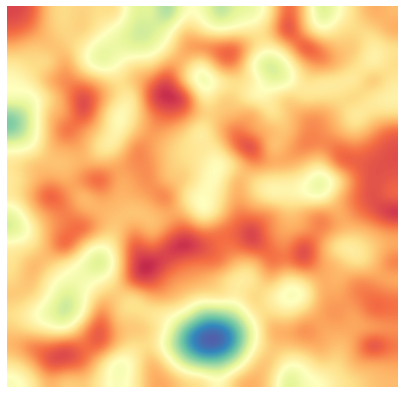

30x30 grid - 120 epochs:


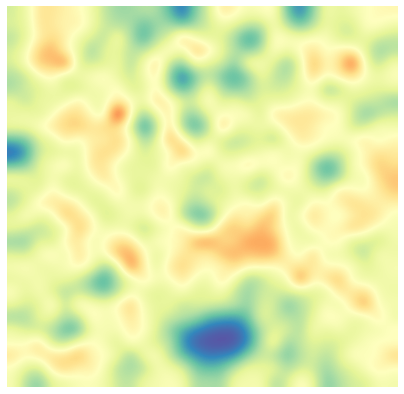

45x45 grid - 150 epochs:


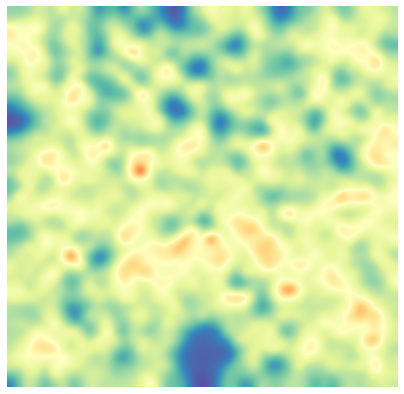

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [236]:
# som1 = joblib.load('som_23x23_5000_120.pkl')
# som2 = joblib.load('som_30x30_5000_100.pkl')
# som3 = joblib.load('som_45x45_5000_150.pkl')
# print('\nSize and Training Epochs on SOM Clustering Results\n')
# print('23x23 grid - 100 epochs:')
# som1.view_umatrix(bestmatches = False, colorbar = False, figsize = (7, 7))
# print('30x30 grid - 120 epochs:')
# som2.view_umatrix(bestmatches = False, colorbar = False, figsize = (7, 7))
# print('45x45 grid - 150 epochs:')
# som3.view_umatrix(bestmatches = False, colorbar = False, figsize = (7, 7))

### Αποθήκευση & Ανάκτηση Χαρτών
Χρησιμοποιώντας τη βιβλιοθήκη `joblib` αποθηκεύουμε και επανακτούμε τους SOM με το clustering τους. Εισάγουμε το cell εδώ (πριν το clustering). Στην πράξη αποθηκεύουμε **αφού** εξάγουμε τα clusters με `Kmeans()`: 

In [137]:
import joblib

#joblib.dump(som, 'som_45x45_5000_150.pkl') 

#som = joblib.load('som_23x23_5000_120.pkl')
#som = joblib.load('som_15x25_5000_120.pkl')
som = joblib.load('som_30x30_5000_100.pkl')
#som = joblib.load('som_45x45_5000_150.pkl')

## Best Matching Units

Αφου εκαπιδεύσουμε το χάρτη, αποθηκεύουμε σε μια λίστα τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία:

In [138]:
bmus = som.bmus
print(len(bmus))
print(bmus[0:6])

5000
[[ 9 28]
 [18  2]
 [28 21]
 [29 20]
 [14 25]
 [26  0]]


Αποθηκεύουμε επίσης τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες.<br>Ως αριθμό νευρώνα θεωρούμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus:

In [139]:
ubmus, indices = np.unique(bmus, return_inverse = True, axis = 0)
print(len(indices))
print(indices[0:6])

5000
[214 375 606 632 307 541]


## Ομαδοποίηση (Clustering)
Θα ομαδοποιήσουμε τους νευρώνες του SOM, χρησιμοποιώντας την `Kmeans` από τη υποβιβλιοθήκη `skearn.cluster` για το clustering:

In [149]:
from sklearn.cluster import KMeans

algorithm = KMeans(n_clusters = 30)
som.cluster(algorithm = algorithm)

## Οπτικοποίηση

Ορίζουμε ως (τελικό) μέγεθος 30x30 νευρώνες και 100 εποχές για την εκπαίδευση του χάρτη, μιας και τα μεγαλύτερα grid αποσυνέθεταν πολύ το ήδη μικρό μας dataset (πχ πολλά clusters για `Drama`, `Comedy` κλπ). Θα αναλύσουμε παρακάτω τη διαδικασία επιλογής παραμέτρων. Αυτός είναι ο u-matrix με τους 30x30 νευρώνες. Όσο αυξάναμε τους νευρώνες, τόσο έτειναν να σχηματίζονται εντονότερες περιοχές, αλλά αυτό οδηγούσε και σε διάσπαση clusters με κυρίαρχες κατηγορίες που θα θέλαμε να ομαδοποιούνται μαζι.

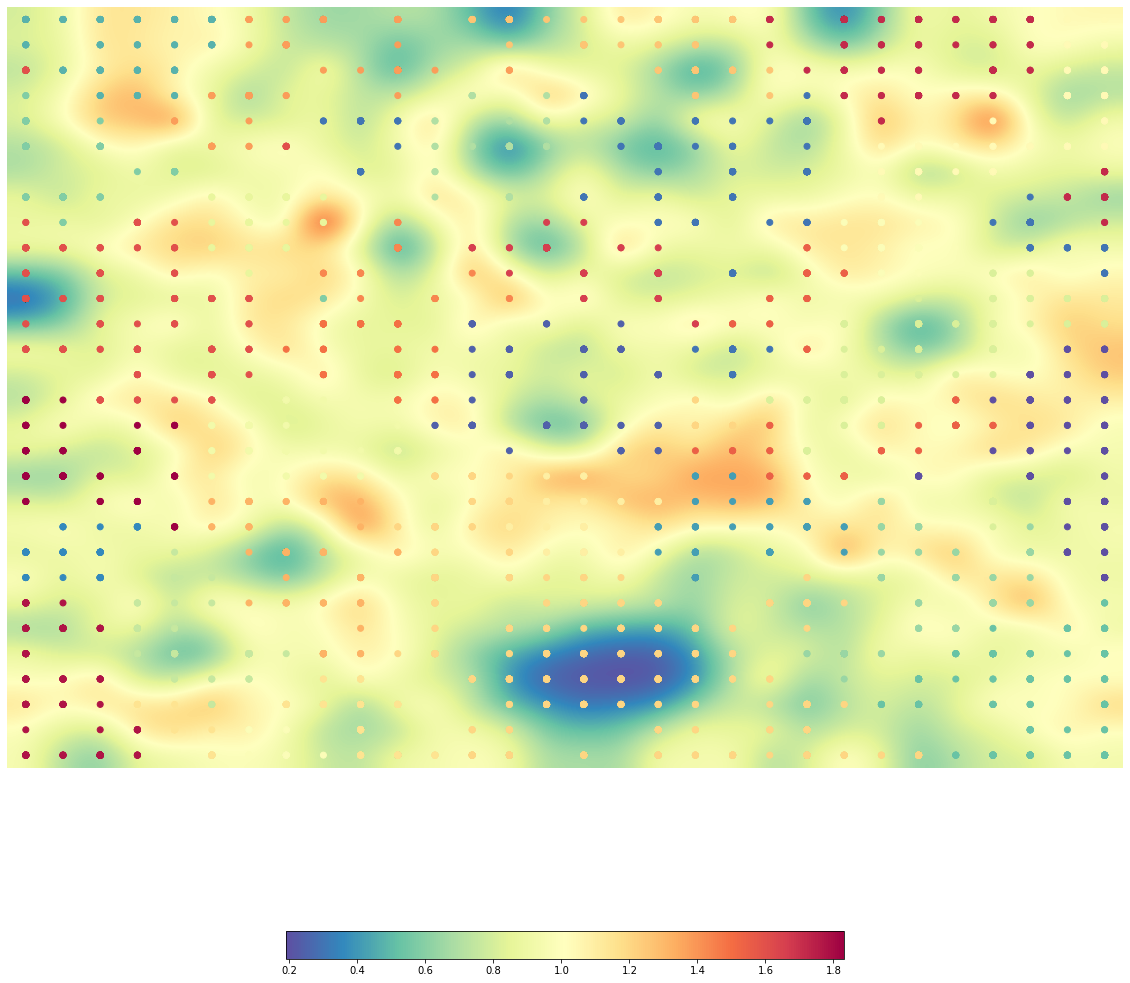

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [150]:
import matplotlib as plt
%matplotlib inline

som.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))

In [158]:
n_rows = n_columns = 30

Ο 30x30 πίνακας, δεν τυπώνεται καλά, αλλά με λίγη προσπάθεια εξάγουμε την απαραίτητη πληροφορία (ποιο cluster τοποθετήθηκε σε ποιο σημείο):

In [195]:
count = np.full((len(np.unique(som.clusters))),0)

for i in range(n_rows):
    for j in range(n_columns):
        count[som.clusters[i][j]] += 1
        
print(som.clusters)
print(np.argsort(count))
print(np.sort(count))

[[ 5  5  5  5  5  5 21 21 21 21 21 21 19 19 19 19 19 19 19 19 27 27 27 27
  27 27 27 27 15 15]
 [ 5  5  5  5  5  5 21 21 21 21 21 21 19 19 19 19 19 19 19 19 27 27 27 27
  27 27 27 27 15 15]
 [25  5  5  5  5  5 21 21 21 21 21 21 21 21 19 19 19 19 19 19 19 27 27 27
  27 27 27 27 15 15]
 [ 7  5  5  5  5 21 21 21 21 21 21 21  9  9  9  2  2 19 19 19 19  2 27 27
  27 27 27 15 15 15]
 [ 7  7  7  5 21 21 21 21  2  2  2  9  9  9  9  2  2  2  2  2  2  2  2 27
  27 27 15 15 15 15]
 [ 7  7  7  7  7 21 21 25  2  2  2  9  9  9  9  9  2  2  2  2  2  2  2 15
  15 15 15 15 15 15]
 [ 7  7  7  7  7  7 12 12  2  2  2  9  9  9  9  2  2  2  2  2  2  2  2 15
  15 15 15 15 15 27]
 [ 7  7  7 25  7 12 12 12 12  2 22  9  9  9  9  2  2  2  2  2  2  2  2 15
  15 15 15  2 27 27]
 [25  7 25 25 25 12 12 12 12 22 22 22 26 26 26 26 26  2  2  2  2  2 14 14
  14 14  2  2  2 27]
 [25 25 25 25 25 12 12 12 12 22 22 22 26 26 26 26 26 26  2  2  2 24 14 14
  14 14  2  2  2  2]
 [25 25 25 25 25 25 12 12 22 22 22 22 22 26 26 26 

## Σημασιολογική Ερμηνεία
Έχοντας πλέον τον χάρτη, μπορούμε να ερμηνεύσουμε το περιεχόμενο των clusters, την τοπολογία που απεικονίζεται στον u-matrix καθώς και να επανοργανώσουμε τα δεδομένα μας για μια ποιοτική μέτρηση της ακρίβειας του `clustering`.

Υλοποιήσαμε τις 3 συναρτήσεις που προτείνονται στην εκφώνηση (+ βοηθητική `stats_printer`) που αποτελούν το ποιοτικό κριτήριο επισκόπησης, με βάση το οποίο θα αξιολογήσουμε την ακρίβεια της ομαδοποίησης ταινιών στο χάρτη:

In [181]:
def stats_printer(ids, stats, max_rec):
    s = [[str(e) for e in row] for row in stats]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    #print('_________Name:',stats[0][0], end = '')
    print('_________Movies Number:' , len(ids))
    print('\n'.join(table[0:max_rec]))

In [161]:
def print_categories_stats(ids, max_rec):    
    cluster_categories = []
    for ID in ids:
        cats = np.array(categories[ID][0].split(','))        
        for i in range(len(cats)):
            cats[i] = np.char.strip(cats[i])
        cluster_categories.extend(cats)
        
    np.ravel(cluster_categories)
    #un = np.unique(cluster_categories)
    unique, counts = np.unique(cluster_categories, return_counts = True)
    stats = sorted(list(zip(unique, counts)), key = lambda tup: tup[1], reverse = True)
    stats_printer(ids, stats, max_rec)

In [162]:
def neuron_movies_report(neurons, max_rec):
    ids = []
    for neuron in neurons:
        neuron_movies = np.where(indices == neuron)
        ids.extend(neuron_movies[0].tolist())
    print_categories_stats(ids, max_rec)

In [163]:
def print_cluster_neurons_movies_report(cluster, max_rec):
    (row, column) = np.where(som.clusters == cluster)
    bmu = np.column_stack((column, row))
    ubmu_position = []
    for i in bmu:
        for j in range(len(ubmus)):
            if (np.array_equal(ubmus[j], i)):
                ubmu_position.append(j)
    neuron_movies_report(ubmu_position, max_rec)

In [164]:
for i in range(30):
    print('_________Cluster:',i, end = '')
    print_cluster_neurons_movies_report(i,6)
    for i in range(23):
        print('_', end = " ") 
    print('\n')

_________Cluster: 0_________Movies: 191
"Action/Adventure"                        	190
"Action"                                  	183
"Thriller"                                	118
"Comedy"                                  	60 
"Crime Fiction"                           	59 
"World cinema"                            	52 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

_________Cluster: 1_________Movies: 137
"Black-and-white"          	136
"Drama"                    	94 
"Romance Film"             	22 
"Adventure"                	15 
"Melodrama"                	13 
"War film"                 	12 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

_________Cluster: 2_________Movies: 329
"Science Fiction"                         	57
"Adventure"                               	44
"Japanese Movies"                         	42
"Fantasy"                                 	29
"Animation"                               	28
"Chinese Movies"                          	22
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Βλέπουμε ότι οι ταινίες που ανήκουν σε συχνά εμφανιζόμενες κατηγορίες, ομαδοποιήθηκαν σε μεγάλα clusters, όπως το `Drama`:

In [182]:
print_cluster_neurons_movies_report(18,4)

_________Movies Number: 826
"Drama"                    	825
"Crime Fiction"            	100
"Family Film"              	55 
"Family Drama"             	45 


Εμφανίστηκαν και άλλα clusters στα οποία κυριαρχεί το `Drama`, αλλά μπορούμε από τις υπόλοιπες κατηγορίες να ερμηνεύσουμε το περιέχόμενο του cluster. Για παράδειγμα, `Drama` σε ταινίες πολέμου:

In [183]:
print_cluster_neurons_movies_report(4,6)

_________Movies Number: 85
"Drama"                                   	84
"War film"                                	80
"Action"                                  	33
"Action/Adventure"                        	24
"History"                                 	17
"World cinema"                            	14


Σε βιογραφίες-ταινίες εποχής:

In [184]:
print_cluster_neurons_movies_report(16,6)

_________Movies Number: 55
"Drama"                 	54
"Biographical film"     	40
"Biography"             	29
"Period piece"          	27
"Biopic [feature]"      	25
"Political drama"       	10


Στο cluster των ταινιών του παγκόσμιου κινηματογράφου:

In [185]:
print_cluster_neurons_movies_report(17,6)

_________Movies Number: 131
"Drama"                    	131
"World cinema"             	131
"Japanese Movies"          	21 
"Thriller"                 	21 
"Art film"                 	16 
"Indie"                    	14 


Σε ρομαντικές ταινίες:

In [186]:
print_cluster_neurons_movies_report(28,6)

_________Movies Number: 211
"Drama"                      	211
"Romance Film"               	210
"Romantic drama"             	205
"World cinema"               	100
"Period piece"               	49 
"Musical"                    	39 


Σχεδόν ίδια εικόνα παρατηρούμε για τις κατηγορίες `Comedy`, `Action`, `Romance`, `Thriller`. Παράλληλα, έχουμε κυριαρχία μιας κατηγορίας στη μεγάλη πλειοψηφία των clusters. Πχ clusters για ασπρόμαυρες ταινίες και βουβό κινηματογράφο:

In [187]:
print_cluster_neurons_movies_report(1,3)
print_cluster_neurons_movies_report(22,3)

_________Movies Number: 137
"Black-and-white"          	136
"Drama"                    	94 
"Romance Film"             	22 
_________Movies Number: 57
"Silent film"     	57
"Black-and-white" 	12
"Short Film"      	7 


Clusters για Crime Thriller / Horror Thriller / Horror ταινίες:

In [180]:
print_cluster_neurons_movies_report(6,3)
print_cluster_neurons_movies_report(15,3)
print_cluster_neurons_movies_report(27,3)

_________Movies: 248
"Thriller"                	242
"Drama"                   	154
"Crime Thriller"          	145
_________Movies: 178
"Thriller"                   	177
"Horror"                     	126
"Science Fiction"            	33 
_________Movies: 240
"Horror"                   	238
"Slasher"                  	58 
"Science Fiction"          	42 


Animated & Family ταινίες:

In [197]:
print_cluster_neurons_movies_report(5,5)
print_cluster_neurons_movies_report(21,5)

_________Movies Number: 135
"Family Film"              	129
"Adventure"                	102
"Children's/Family"        	67 
"Comedy"                   	64 
"Animation"                	59 
_________Movies Number: 151
"Animation"         	148
"Short Film"        	137
"Family Film"       	86 
"Comedy"            	45 
"Comedy film"       	44 


Ντοκιμαντέρ:

In [198]:
print_cluster_neurons_movies_report(19,5)

_________Movies Number: 196
"Documentary"                	120
"Short Film"                 	94 
"Indie"                      	20 
"Biography"                  	15 
"Culture & Society"          	15 


Action - Adventure ταινιες:

In [190]:
print_cluster_neurons_movies_report(11,5)

_________Movies Number: 203
"Action"                                  	203
"Adventure"                               	63 
"Science Fiction"                         	38 
"Fantasy"                                 	26 
"Thriller"                                	26 


Ο χάρτης με μεγαλύτερη διάσταση, ομαδοποιούσε ακριβέστερα τα μικρα clusters, αλλά αποσυνέθετε τα μεγάλα και στο πλαίσιο της εργασίας ανέβαινε πολύ ο αριθμός των cluster που χρειαζόμασταν για να περιγράψουμε όλες τις ομάδες. Επιπλέον ένα από όλα τα cluster δε θα είχε κάποια προφανή κυρίαρχη κατηγορία. Στην περίπτωση αυτου του SOM/clusters ήταν το παρακάτω, που ίσως τείνει προς την κατηγορία των anime:

In [196]:
print_cluster_neurons_movies_report(2,5)

_________Movies Number: 329
"Science Fiction"                         	57
"Adventure"                               	44
"Japanese Movies"                         	42
"Fantasy"                                 	29
"Animation"                               	28


## Συμπεράσματα
<div style="width:image width px; 
            font-size:90%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.1em;  
            background-color: rgba(232, 991, 755, 0.7);">
    <img src="https://miro.medium.com/max/700/1*F5_SVcLW-9AGkc6vrSwJiw.png" 
         alt="alternate text" 
         width=635
         style="padding-bottom:0.1em;"/>
        Kohonen Self-Organizing Map @towardsdatascience.com<br> 
        <a href="https://towardsdatascience.com/kohonen-self-organizing-maps-a29040d688da" 
           style="float: right;"> 
           Πηγή 
        </a>
    </div>
</div>  
Πειραματιστήκαμε με διάφορα μεγέθη χαρτών και clusters, και συλλέξαμε ορισμένες παρατηρήσεις/σχόλια:

### Πλήθος των Clusters
* Όσο ο αριθμός των clusters αυξάνεται, ομαδοποιούνται ακριβέστερα οι σπανιότερα εμφανιζόμενες κατηγορίες. Στο πλαίσιο του sample μας αυτό συνέβη για κατηγορίες όπως Musical, Silent Movies, Political Cinema, Short Film κλπ. Παράλληλα όμως, οι συχνά εμφανιζόμενες κατηγορίες (Drama, Comedy, Action, Thriller κλπ) διαμερίζονται σε clusters που χαρακτηρίζονται περισσότερο από τις αμέσως επόμενες πληθυσμιακά κατηγορίες στα νέα clusters (πχ η Drama ως κυρίαρχη κατηγορία σε clusters όπως Romance-Drama, Action-Drama, Comedy-Drama κλπ).

* Κατ' αντιστοιχία, όσο τα clusters μειώνονταν, οι συχνές κατηγορίες συγκεντρώνονταν σε πολυπληθή-dominant clusters (ως και $\frac{1}{5}$ του sample κατέληγε στο καθένα) αλλά οι σπάνιες κατηγοριές "στοιβάζονταν" χωρίς νοηματική συνοχή.

Θεωρούμε ότι το ιδανικό βρίσκεται στην ισορροπία του παραπάνω διπόλου. Θέλουμε καλή ομαδοποίηση στις ταινίες με σπάνια εμφανιζόμενες κατηγορίες, στο βαθμό που αυτό δε "σπάει" τα clusters των ταινιών με συχνά εμφανιζόμενες κατηγορίες σε πολλά μικρότερα clusters. 

### Τοπολογία Χάρτη
Η τοπολογία του χάρτη, ανάμεσα στις δοκιμές, παρουσίασε κάποια σταθερά μοτίβα. Σχηματικά, είχαμε: Comedy - Drama και Action - Romance ως Βορρά - Νότο και Δύση - Ανατολή αντίστοιχα, στις περιοχές του umatrix. Ταινίες με κατηγορίες όπως Drama, Comedy,  Romance, Action, Thriller σχημάτιζαν πολλαπλές ή μοναδικές ιώδεις κυρτές επιφάνειες σε κεντρικα σημεία του χάρτη και πολλές φορές το clustering με k-means αναδιένειμε νευρώνες στα σύνορά. Για παράδειγμα, το/τα clusters που κυριαρχούσε η κατηγορία Drama συνόρευαν κατά κανόνα με Romance, Action και Comedy στις κεντρικές περιοχές του χάρτη και Musical, World Cinema και Political Cinema στις εξωτερικές περιοχές του χάρτη. Αντίστοιχα μοτίβα παρατηρήσαμε για όλα τα clusters με κυρίαρχες τις συχνά εμφανιζόμενες κατηγορίες. Ιδιαίτερο ενδιαφέρον είχε η γειτνίαση του cluster των Horror Movies με τις κωμωδίες.

### Ακρίβεια
Δεδομένης της έλλειψης κάποιου πλήρως ποσοτικού μέτρου για την εξαγωγή της ακρίβειας του κάθε clustering (δεν υπάρχει ντετερμινιστική τοπολογία, μειώνονται και οι διαστάσεις), θεωρήσαμε ως λογικό στόχο να πετύχουμε μια ομαδοποίηση κατά την οποία θα είναι προφανής η υπεροχή μίας κατηγορίας (ει δυνατόν κάθε ταινία του cluster να ανήκει σε αυτήν) και παράλληλα οι περιοχές του χάρτη που απεικονίζουν clusters ταινιών με συχνές κατηγορίες (εν γένει κυρτές μπλε περιοχές με ασαφή όρια) να ομαδοποιούνται σε ένα (ή λίγα και ερμηνεύσιμα) cluster.

Σχεδόν σε όλες τις δοκιμές, υπήρχαν λίγα clusters με ετερόκλητες κατηγορίες. Χαρακτηριστικό ήταν ένα "σύμπλεγμα" κοντινών μικρων clusters που χαρακτηρίζονταν ως ένα cluster, χωρίς κάποια κυρίαρχη κατηγορία στο εσωτερικό του. 
Καταφέραμε να τα αναομαδοποιήσουμε, εντοπίζοντας τη θέση τους στο χάρτη και παίζοντας με αριθμό cluster (k-means) και μέγεθος grid (SOM) για να μεταφερθουν σε γειτονικά clusters. 


# Τέλος Εργασίας